In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd


import lalsimulation.gwsignal.core.waveform as wfm
import astropy.units as u
from gwpy.frequencyseries import FrequencySeries

from gw_signal_tools.inner_product import optimize_overlap
from gw_signal_tools.waveform_utils import get_wf_generator
from gw_signal_tools.fisher import (
    get_waveform_derivative_1D, get_waveform_derivative_1D_with_convergence,
    fisher_matrix, FisherMatrix
)

/home/user/miniconda3/envs/gw_signal_tools_light/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [2]:
from gw_signal_tools import PLOT_STYLE_SHEET
plt.style.use(PLOT_STYLE_SHEET)

In [3]:
f_min = 20.*u.Hz  # Cutoff frequency
f_max = 1024. * u.Hz  # Cutoff from PSD
delta_f = 2**-6 * u.Hz
f_ref = f_min  # Frequency where we specify spins


wf_params = {
    'total_mass': 50.*u.Msun,
    # 'mass_ratio': 0.05*u.dimensionless_unscaled,
    # 'mass_ratio': 0.15*u.dimensionless_unscaled,
    'mass_ratio': 0.5*u.dimensionless_unscaled,
    'f22_start': f_min,
    'f_max': f_max,
    'deltaF': delta_f,
    'f22_ref': f_ref,
    'phi_ref': 0.*u.rad,
    # 'distance': 1.*u.Mpc,
    'distance': 440.*u.Mpc,  # As expected, systematic error is independent of SNR and thus amplitude given by D_L
    'inclination': 0.*u.rad,
    'eccentricity': 0.*u.dimensionless_unscaled,
    'longAscNodes': 0.*u.rad,
    'meanPerAno': 0.*u.rad,
    'condition': 0
}

In [4]:
# Make sure mass1 and mass2 are not in default_dict (makes messy behaviour)
import lalsimulation.gwsignal.core.parameter_conventions as pc
pc.default_dict.pop('mass1', None);
pc.default_dict.pop('mass2', None);

# Fisher Matrix Testing

## Recovering $t_0$-Bias

In [5]:
ref_model = 'IMRPhenomXPHM'

ref_generator = get_wf_generator(ref_model)

/home/user/miniconda3/envs/gw_signal_tools_light/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [6]:
t_shift = 1e-3*u.s

def shifted_wf_gen(wf_params):
    wf = ref_generator(wf_params)
    return wf * np.exp(-2.j*np.pi*wf.frequencies*t_shift)

In [7]:
wf1_shifted, wf2_shifted, opt_params = optimize_overlap(
    wf_params,
    ref_generator,
    shifted_wf_gen,
    opt_params=['time', 'phase'],
    # opt_params=['time'],
    min_dt_prec=1e-5
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [8]:
fisher_t_bias = FisherMatrix(
    wf_params,
    ['time', 'phase'],
    # 'time',
    shifted_wf_gen,
    direct_computation=False,
    min_dt_prec=1e-5*u.s
)

sys_error_t_bias_non_opt = fisher_t_bias.systematic_error(
    ref_generator,
    optimize=False
)


sys_error_t_bias_opt, opt_info = fisher_t_bias.systematic_error(
    ref_generator,
    # optimize=['time', 'phase']
    optimize=['time']
    # Results for both choices are equal
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [9]:
print(t_shift)
print(opt_params['time'])
print(sys_error_t_bias_non_opt[0,0])
print(sys_error_t_bias_opt[0,0])

0.001 s
-0.00099945068359375 1 / Hz
-0.0005971830525189386 s
-0.0009999999999211048 s


In [10]:
# t_shift_from_opt = []
# t_bias_non_opt = []
# t_bias_opt = []

# # t_shifts = np.linspace(1e-6, 1e-2, num=16)*u.s
# t_shifts = 10**np.linspace(-6, -2, num=16)*u.s
# # t_shifts = np.linspace(1e-6, 1e-3, num=12)*u.s


# wf1 = ref_generator(wf_params)

# for shift in t_shifts:
#     # def shifted_wf_gen(wf_params):
#     #     wf = ref_generator(wf_params)
#     #     # return wf * np.exp(-2.j*np.pi*wf.frequencies*shift)
#     #     return wf * np.exp(-2.j*np.pi*wf.frequencies*(-shift))  # To have same in plot
    

#     # _, _, opt_params = optimize_overlap(
#     #     wf_params,
#     #     ref_generator,
#     #     shifted_wf_gen,
#     #     opt_params=['time', 'phase'],
#     #     min_dt_prec=1e-5*u.s
#     # )

#     # t_shift_from_opt += [
#     #     opt_params['time'].value  # Otherwise error when reshaping
#     # ]
#     # Kind of unnecessary, optimization in sys error does same

    
#     # fisher = FisherMatrix(
#     #     wf_params,
#     #     ['time', 'phase'],
#     #     # 'time',
#     #     shifted_wf_gen,
#     #     direct_computation=False,
#     #     min_dt_prec=1e-5*u.s
#     # )
    
#     # t_bias_non_opt += [
#     #     fisher.systematic_error(
#     #         ref_generator,
#     #         'time',
#     #         optimize=False
#     #     )
#     # ]
    
#     # t_bias_opt += [
#     #     fisher.systematic_error(
#     #         ref_generator,
#     #         'time',
#     #         # optimize=True,  # Equivalent, but less explicit than below
#     #         optimize=['time', 'phase'],
#     #         return_opt_info=False
#     #     )
#     # ]


#     # Testing sign from Potsdam paper, where shifted by +shift is reference
#     # -> should be equivalent to our tests, where we shift biased WF
#     #    by -shift (it is, luckily)
#     def shifted_wf_gen(wf_params):
#         wf = ref_generator(wf_params)
#         return wf * np.exp(-2.j*np.pi*wf.frequencies*shift)
#         # return wf * np.exp(-2.j*np.pi*wf.frequencies*(-shift))  # To have same in plot
    

#     fisher = FisherMatrix(
#         wf_params,
#         ['time', 'phase'],
#         # 'time',
#         ref_generator,
#         direct_computation=False,
#         min_dt_prec=1e-5*u.s
#     )
    
#     t_bias_non_opt += [
#         fisher.systematic_error(
#             shifted_wf_gen,
#             'time',
#             optimize=False
#         )
#     ]
    
#     t_bias_opt += [
#         fisher.systematic_error(
#             shifted_wf_gen,
#             'time',
#             # optimize=True,  # Equivalent, but less explicit than below
#             optimize=['time', 'phase'],
#             return_opt_info=False
#         )
#     ]

# t_bias_non_opt = np.reshape(t_bias_non_opt, -1)
# t_bias_opt = np.reshape(t_bias_opt, -1)
# t_shift_from_opt = np.reshape(t_shift_from_opt, -1)

In [11]:
t_shift_from_opt = []
t_bias_non_opt = []
t_bias_opt_v1 = []
t_bias_opt_v2 = []
t_bias_opt_v3 = []

t_shifts = 10**np.linspace(-6, -2, num=16)*u.s


wf1 = ref_generator(wf_params)

for shift in t_shifts:
    def shifted_wf_gen(wf_params):
        wf = ref_generator(wf_params)
        return wf * np.exp(-2.j*np.pi*wf.frequencies*shift)
        # return wf * np.exp(-2.j*np.pi*wf.frequencies*(-shift))  # To have same in plot
    

    fisher = FisherMatrix(
        # wf_params,
        wf_params | {'deltaF': 2**-2*u.Hz},
        'time',
        ref_generator,
        direct_computation=False,
        # min_dt_prec=1e-5*u.s,
        df=2**-2,
        min_dt_prec=1e-6*u.s
    )
    
    t_bias_non_opt += [
        fisher.systematic_error(
            shifted_wf_gen,
            'time',
            optimize=False
        )
    ]
    
    t_bias_opt_v1 += [
        fisher.systematic_error(
            shifted_wf_gen,
            'time',
            # optimize=True,  # Equivalent, but less explicit than below
            # optimize=['time', 'phase'],
            optimize=['time'],  # Otherwise we have impact of slight degeneracy between time, phase in overlap optimization, but not in sys error formula (inconsistent)
            return_opt_info=False
        )
    ]
    
    t_bias_opt_v2 += [
        fisher.systematic_error(
            shifted_wf_gen,
            'time',
            # optimize=True,  # Equivalent, but less explicit than below
            optimize=['time', 'phase'],
            # optimize=['time'],  # Otherwise we have impact of slight degeneracy between time, phase in overlap optimization, but not in sys error formula (inconsistent)
            return_opt_info=False
        )
    ]


    fisher = FisherMatrix(
        # wf_params,
        wf_params | {'deltaF': 2**-2*u.Hz},
        ['time', 'phase'],
        ref_generator,
        direct_computation=False,
        # min_dt_prec=1e-5*u.s,
        df=2**-2,
        min_dt_prec=1e-6*u.s
    )
    
    t_bias_opt_v3 += [
        fisher.systematic_error(
            shifted_wf_gen,
            'time',
            # optimize=True,  # Equivalent, but less explicit than below
            optimize=['time', 'phase'],
            # optimize=['time'],  # Otherwise we have impact of slight degeneracy between time, phase in overlap optimization, but not in sys error formula (inconsistent)
            return_opt_info=False
        )
    ]

t_bias_non_opt = np.reshape(t_bias_non_opt, -1)
t_bias_opt_v1 = np.reshape(t_bias_opt_v1, -1)
t_bias_opt_v2 = np.reshape(t_bias_opt_v2, -1)
t_bias_opt_v3 = np.reshape(t_bias_opt_v3, -1)
t_shift_from_opt = np.reshape(t_shift_from_opt, -1)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

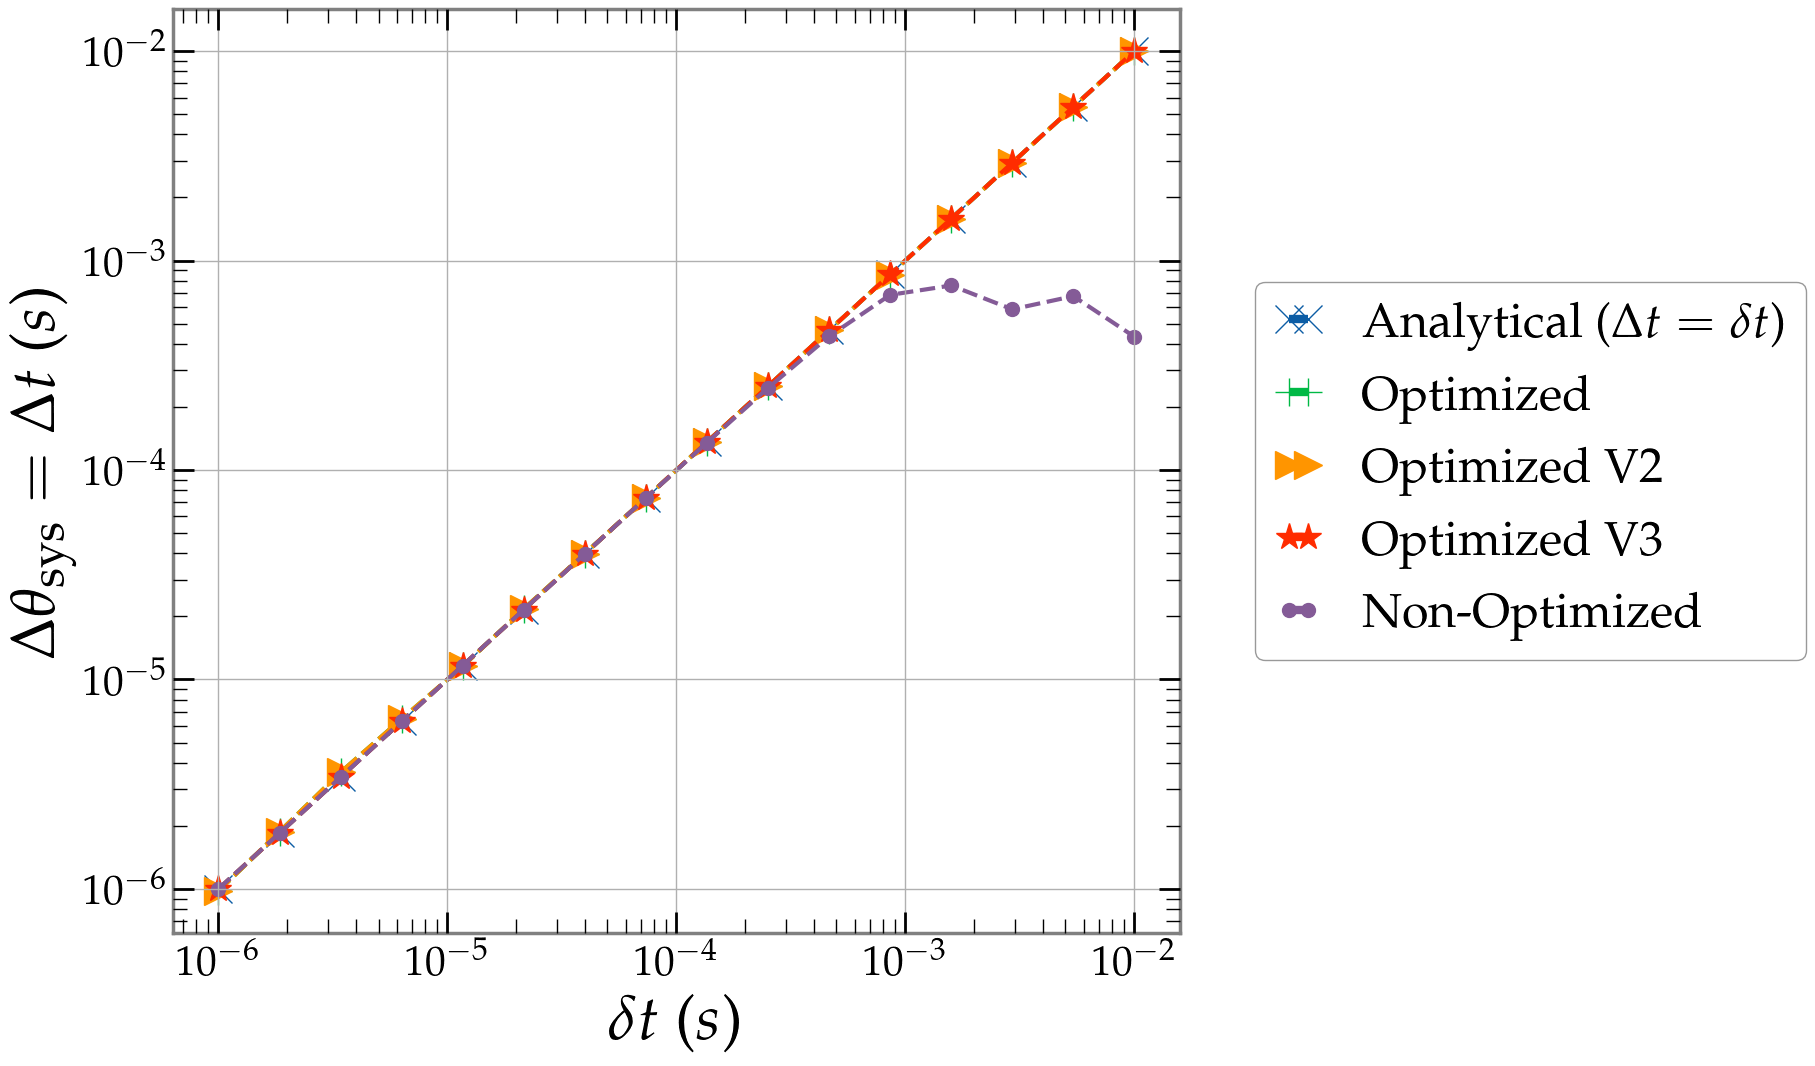

In [12]:
plt.plot(t_shifts, t_shifts, 'x--', label='Analytical ($\Delta t = \delta t$)')
plt.plot(t_shifts, t_bias_opt_v1, '+--', label='Optimized')
plt.plot(t_shifts, t_bias_opt_v2, '>--', label='Optimized V2')
plt.plot(t_shifts, t_bias_opt_v3, '*--', label='Optimized V3')
plt.plot(t_shifts, t_bias_non_opt, '.--', label='Non-Optimized')

plt.xlabel(r'$\delta t$ ($s$)')
plt.ylabel(r'$\Delta \theta_\mathrm{sys} = \Delta t$ ($s$)')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.xscale('log')
plt.yscale('log')


plt.show()

By plotting log-log, we obtain the same shape as Potsdam paper (good)


Here are a few notes on the calculation:

- we only obtain the Potsdam paper results in the same manner when looking at Fisher matrix for time only, not time and phase. This is because point in parameter space seems to have influence on the relative proportions of bias between phase and time (changing has no effect if we shift for time as only parameter, but does have for time and phase as parameters)

- we only obtain perfect agreement in optimized case if we optimize over both time and phase, not just time (for smaller biases at least) and if both are also included in the analysis


Maybe things are harder to distinguish in mismatch for small time shifts? If accuracy we can infer these shifts with is on the order of 1e-6, then this will work fine for shifts of 1e-3, but not be visible for shifts on this order. Maybe balanced by phase?

-> former is definitely true, we had set precision of dt in phase estimation to 1e-5; testing with 1e-6

-> ahhh, indeed gets better with min_dt_prec

*Note*: in order to recover very small biases in $t_0$, we might have to select a very suitable min_dt_prec (otherwise the accuracy in the results might simply be too small to rely on it)

## Recovering $t_0$ and $\phi_0$ bias

In [13]:
t_shift = 1e-5*u.s
phi_shift = 1e-2*u.rad

def shifted_wf_gen(wf_params):
    wf = ref_generator(wf_params)
    return wf * np.exp(-2.j*np.pi*wf.frequencies*t_shift + 1.j*phi_shift)

In [14]:
wf1_shifted, wf2_shifted, opt_params = optimize_overlap(
    wf_params | {'deltaF': 2**-2*u.Hz},
    shifted_wf_gen,
    ref_generator,
    opt_params=['time', 'phase'],
    # opt_params=['time'],
    # Need very small to have very good accuracy. Balance computational cost by decreasing df
    min_dt_prec=1e-6,
    # min_dt_prec=1e-7,  # Great accuracy, but takes pretty long
    df=2**-2
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [15]:
fisher_t_bias = FisherMatrix(
    wf_params,
    ['time', 'phase'],
    # 'time',
    ref_generator,
    direct_computation=False,
    min_dt_prec=1e-5*u.s
)

sys_error_t_bias_non_opt = fisher_t_bias.systematic_error(
    shifted_wf_gen,
    optimize=False
)


sys_error_t_bias_opt, opt_info = fisher_t_bias.systematic_error(
    shifted_wf_gen,
    optimize=True
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [16]:
print(t_shift, phi_shift)
print(opt_params['time'], opt_params['phase'])
print(sys_error_t_bias_non_opt)
print(sys_error_t_bias_opt)

1e-05 s 0.01 rad
9.5367431640625e-06 1 / Hz 0.009856713809962456 rad
array([[<Quantity 9.99986923e-06 s>],
       [<Quantity 0.00999989>]], dtype=object)
array([[<Quantity 9.99999651e-06 s>],
       [<Quantity 0.01>]], dtype=object)


## Recovering $M$-Bias

In [17]:
ref_model = 'IMRPhenomXPHM'

ref_generator = get_wf_generator(ref_model)

/home/user/miniconda3/envs/gw_signal_tools_light/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [18]:
M_shift = 0.2*u.Msun
# M_shift = 2.*u.Msun

def shifted_wf_gen(wf_params):
    return ref_generator(wf_params | {'total_mass': wf_params['total_mass'] - M_shift})

In [19]:
wf1_shifted, wf2_shifted, opt_params = optimize_overlap(
    wf_params,
    ref_generator,
    shifted_wf_gen,
    # opt_params=['total_mass']
    opt_params=['total_mass', 'time', 'phase']
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

When including time and phase in the optimization, the mismatch as a function of $M$-shift is much smoother and does not oscillate, so that higher shifts can be recovered.

In [20]:
fisher_M_bias = FisherMatrix(
    wf_params,
    # 'total_mass',
    ['total_mass', 'time', 'phase'],
    shifted_wf_gen,
    direct_computation=False
)

sys_error_M_bias_non_opt = fisher_M_bias.systematic_error(
    ref_generator,
    optimize=False
)


sys_error_M_bias_opt, opt_info = fisher_M_bias.systematic_error(
    ref_generator,
    optimize=['time', 'phase']
)


sys_error_M_bias_M_opt, M_opt_info = fisher_M_bias.systematic_error(
    ref_generator,
    optimize=['total_mass', 'time', 'phase']
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [21]:
print(M_shift)
print(opt_params['total_mass'] - wf_params['total_mass'])
print(sys_error_M_bias_non_opt[0,0])
print(sys_error_M_bias_opt[0,0])
print(sys_error_M_bias_M_opt[0,0])

0.2 solMass
0.1999664306640625 solMass
0.186571007541817 solMass
0.1970631037149894 solMass
0.20000058955234185 solMass


All of these shifts are equal to the expected shift of $$\Delta \theta_\mathrm{sys} = \theta_\mathrm{bf} - \theta_\mathrm{true} = 0.2$$

We can see that this is the correct result by remembering that the injected reference signal has $M = 50 M_\odot$. The biased model will achieve the best fit with this when it returns the waveform for $M = 50 M_\odot$, which is the case for input $50 M_\odot + \text{shift}$. This is nothing but the $M$-component of $\theta_\mathrm{bf}$.

In [22]:
M_shift_from_opt = []
M_bias_non_opt = []
M_bias_opt = []
M_bias_M_opt = []

# M_shifts = np.linspace(0.2, 1.25, num=10)*u.Msun
M_shifts = np.linspace(1e-2, 0.8, num=10)*u.Msun


wf1 = ref_generator(wf_params)

for shift in M_shifts:
    def shifted_wf_gen(wf_params):
        return ref_generator(wf_params | {'total_mass': wf_params['total_mass'] - shift})

    _, _, opt_params = optimize_overlap(
        wf_params,
        ref_generator,
        shifted_wf_gen,
        # opt_params=['total_mass']
        opt_params=['total_mass', 'time', 'phase']
    )

    M_shift_from_opt += [
        (opt_params['total_mass'] - wf_params['total_mass']).value  # Otherwise error when reshaping
    ]
    # Kind of unnecessary, optimization in sys error does same
    
    fisher_M_bias = FisherMatrix(
        wf_params,
        # 'total_mass',
        ['total_mass', 'time', 'phase'],
        shifted_wf_gen,
        direct_computation=False
    )

    M_bias_non_opt += [
        fisher_M_bias.systematic_error(
            ref_generator,
            'total_mass',
            optimize=False
        )
    ]

    M_bias_opt += [
        fisher_M_bias.systematic_error(
            ref_generator,
            'total_mass',
            optimize=['time', 'phase'],
            return_opt_info=False
        )
    ]

    M_bias_M_opt += [
        fisher_M_bias.systematic_error(
            ref_generator,
            'total_mass',
            optimize=['total_mass', 'time', 'phase'],
            return_opt_info=False
        )
    ]

M_shift_from_opt = np.reshape(M_shift_from_opt, -1)
M_bias_non_opt = np.reshape(M_bias_non_opt, -1)
M_bias_opt = np.reshape(M_bias_opt, -1)
M_bias_M_opt = np.reshape(M_bias_M_opt, -1)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

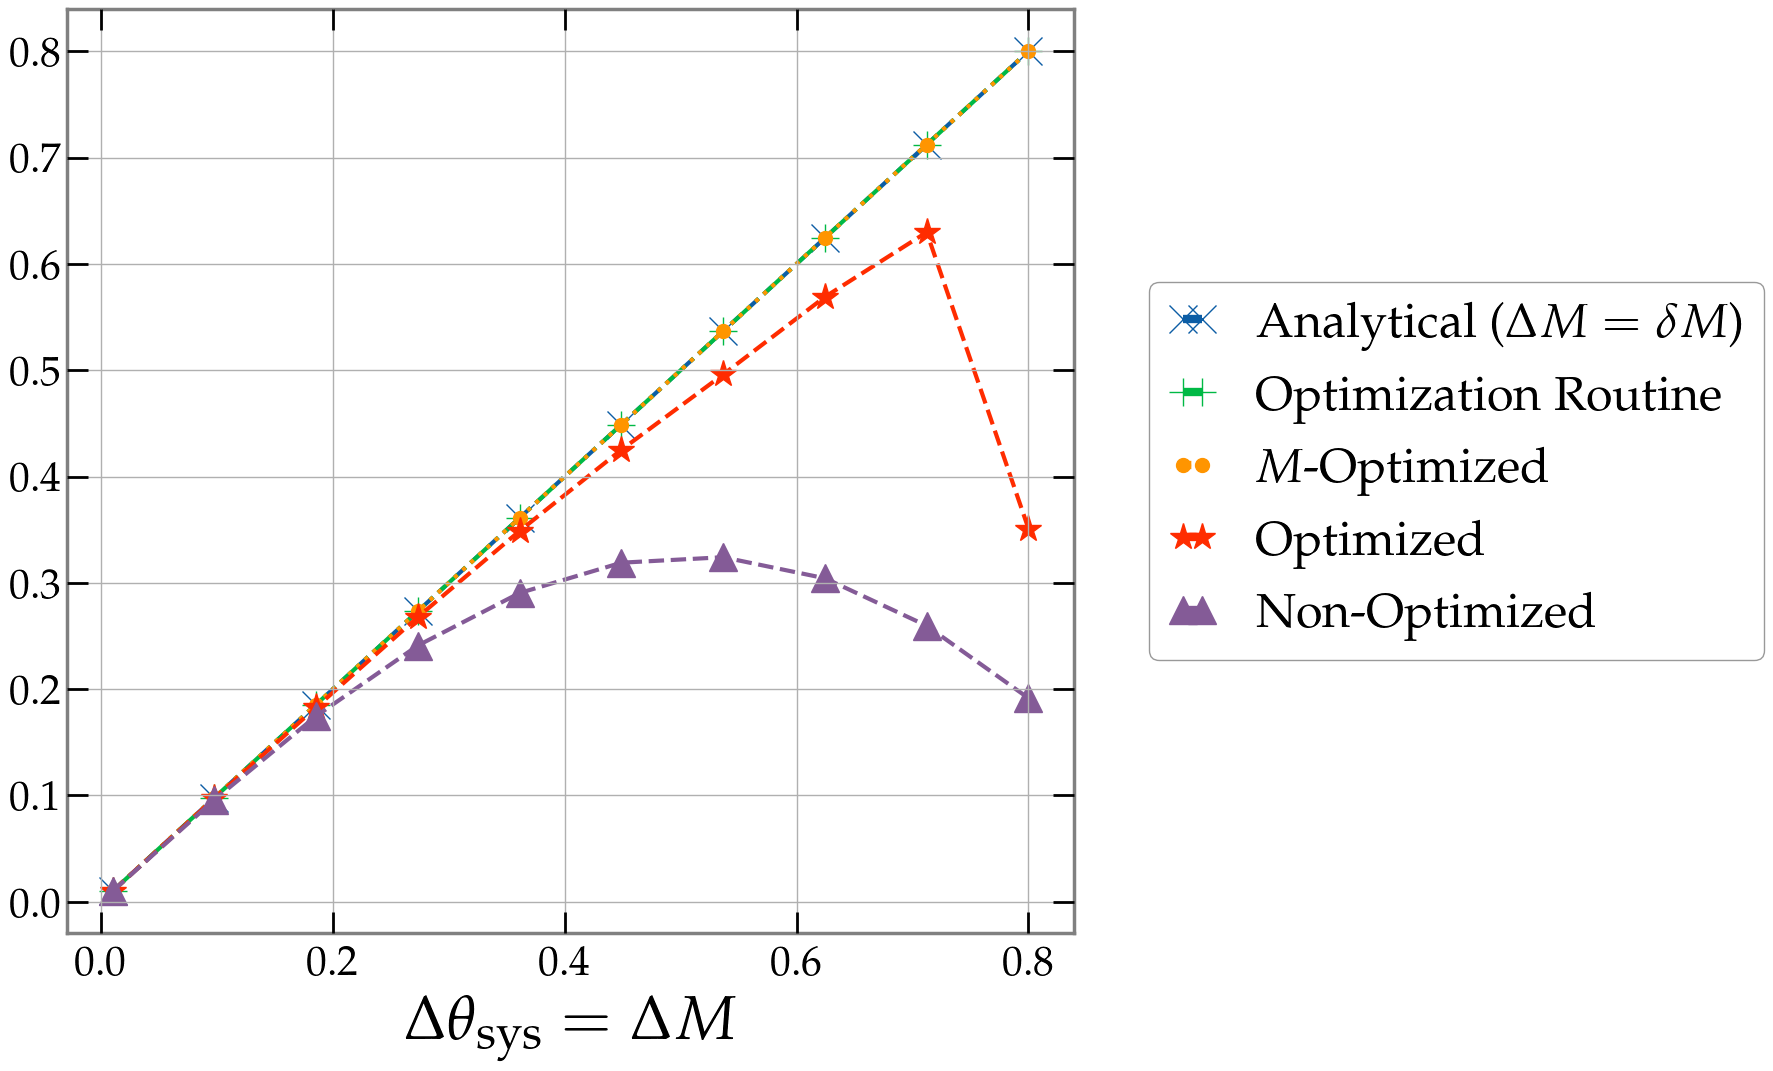

In [23]:
plt.plot(M_shifts, M_shifts, 'x--', label='Analytical ($\Delta M = \delta M$)')
plt.plot(M_shifts, M_shift_from_opt, '+-.', label='Optimization Routine')
plt.plot(M_shifts, M_bias_M_opt, '.:', label='$M$-Optimized')
plt.plot(M_shifts, M_bias_opt, '*--', label='Optimized')
plt.plot(M_shifts, M_bias_non_opt, '^--', label='Non-Optimized')

plt.xlabel(r'$\delta M$')
plt.xlabel(r'$\Delta \theta_\mathrm{sys} = \Delta M$')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.show()

These curves are pretty much expected in that manner. For small biases, all formulas work reasonably well. Optimized one works better than non-optimized. Optimizing over $M$ in the systematic error calculation yields exact results.

## Benchmarking

In [28]:
import cProfile

In [29]:
cProfile.run(
    '''optimize_overlap(
        wf_params,
        ref_generator,
        shifted_wf_gen,
        # opt_params=['total_mass']
        opt_params=['total_mass', 'time', 'phase']
    )''',
    sort=1
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

         961022 function calls (953101 primitive calls) in 10.115 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       34    2.814    0.083    2.822    0.083 {built-in method lalsimulation._lalsimulation.SimInspiralGenerateFDWaveform}
      646    2.525    0.004    2.525    0.004 {built-in method lal._lal.DictInsertREAL8Value}
       68    0.537    0.008    0.799    0.012 array.py:319(epoch)
       34    0.430    0.013    8.123    0.239 waveform.py:334(generate_fd_waveform)
       68    0.267    0.004    1.111    0.016 waveform.py:525(to_gwpy_Series)
       68    0.267    0.004    0.267    0.004 {built-in method lalsimulation._lalsimulation.SimInspiralImplementedFDApproximants}
       68    0.264    0.004    0.264    0.004 {built-in method lalsimulation._lalsimulation.SimInspiralImplementedTDApproximants}
       68    0.262    0.004    0.262    0.004 _tconvert.py:96(to_gps)
       34    0.140    0.004    0.140    0.004 {b

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is